# Data pre-processing

In [8]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [9]:
# Load the data from the uploaded CSV file
file_path = "/content/combined_mutation_CNV.csv"
data = pd.read_csv(file_path)

# Separate the features and labels
labels = data["Subtype"].values
features = data.drop(columns=["Subtype", "Sample"]).values

# Convert to numpy arrays
labels = np.array(labels)
labels[labels=='PDM'] = 0
labels[labels=='SCM'] = 1

features = np.array(features)

# Output the results
print("Labels:", labels.shape)
print("Features:", features.shape)


Labels: (43,)
Features: (43, 656)


In [10]:
# Create a MinMaxScaler object with a feature range of -1 to 1
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Fit the MinMaxScaler to the data (excluding the last column) and transform the data
# This scales the features to the specified range (-1 to 1)
features = min_max_Scalar.fit_transform(features)

# Convert the transformed data to a NumPy array
features = np.asarray(features)

# Encode labels if they are not integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# PCA

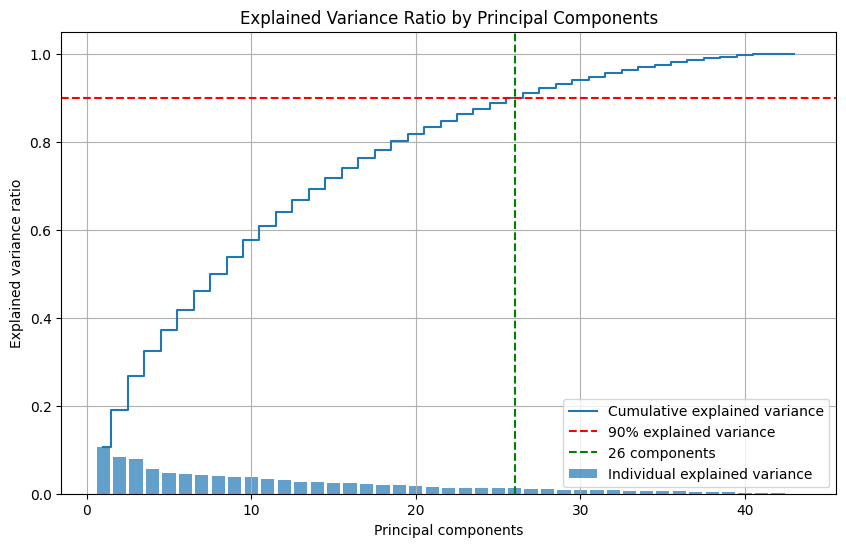

Number of components needed to explain 90% of the variance: 26


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the number of components needed to explain 90% variance
n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1

# Plot explained variance ratio and cumulative explained variance
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.7,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    where="mid",
    label="Cumulative explained variance",
)
plt.axhline(y=0.90, color="r", linestyle="--", label="90% explained variance")
plt.axvline(
    x=n_components_90, color="g", linestyle="--", label=f"{n_components_90} components"
)

plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.title("Explained Variance Ratio by Principal Components")
plt.grid()
plt.show()

# Print the number of components needed to explain 90% of the variance
print(f"Number of components needed to explain 90% of the variance: {n_components_90}")


In [12]:
# Apply PCA
pca = PCA(n_components=26)
new_features = pca.fit_transform(features)

new_features.shape

(43, 26)

# PSO

In [13]:
from numpy.random import rand

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


# Error rate calculation
def error_rate(x, opts, model):
    fold = opts["fold"]
    xt, yt, xv, yv = fold["xt"], fold["yt"], fold["xv"], fold["yv"]

    num_train, num_valid = xt.shape[0], xv.shape[0]
    xtrain_selected = xt[:, x == 1]
    ytrain_reshaped = yt.reshape(num_train)
    xvalid_selected = xv[:, x == 1]
    yvalid_reshaped = yv.reshape(num_valid)

    mdl = model()
    mdl.fit(xtrain_selected, ytrain_reshaped)
    ypred = mdl.predict(xvalid_selected)
    accuracy = np.sum(yvalid_reshaped == ypred) / num_valid
    return 1 - accuracy


# Cost function combining error rate and feature size
def Fun(x, opts, model):
    alpha = 0.99
    beta = 1 - alpha
    max_feat = len(x)
    num_feat = np.sum(x == 1)

    if num_feat == 0:
        return 1

    error = error_rate(x, opts, model)
    return alpha * error + beta * (num_feat / max_feat)


# Initialize particle positions
def init_position(lb, ub, N, dim):
    return lb + (ub - lb) * rand(N, dim)


# Initialize particle velocities
def init_velocity(lb, ub, N, dim):
    Vmax = (ub - lb) / 2
    Vmin = -Vmax
    V = Vmin + (Vmax - Vmin) * rand(N, dim)
    return V, Vmax, Vmin


# Binary conversion of positions
def binary_conversion(X, thres, N, dim):
    return (X > thres).astype(int)


# Ensure boundaries are respected
def boundary(x, lb, ub):
    return np.clip(x, lb, ub)


# Particle Swarm Optimization for feature selection
def pso_jfs(xtrain, ytrain, opts, model):
    ub, lb = 1, 0
    thres, w, c1, c2 = 0.5, 0.9, 2, 2

    N, max_iter = opts["N"], opts["T"]
    w = opts.get("w", w)
    c1 = opts.get("c1", c1)
    c2 = opts.get("c2", c2)

    dim = xtrain.shape[1]
    lb = np.full(dim, lb)
    ub = np.full(dim, ub)

    X = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim)
    fit = np.full(N, np.inf)
    Xgb = np.zeros(dim)
    fitG = np.inf
    Xpb = X.copy()
    fitP = np.full(N, np.inf)
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)

        for i in range(N):
            fit[i] = Fun(Xbin[i], opts, model)
            if fit[i] < fitP[i]:
                Xpb[i] = X[i]
                fitP[i] = fit[i]
            if fitP[i] < fitG:
                Xgb = Xpb[i]
                fitG = fitP[i]

        curve[t] = fitG
        print(f"Iteration: {t+1}, Best (PSO): {curve[t]}")

        for i in range(N):
            for d in range(dim):
                r1, r2 = rand(), rand()
                V[i, d] = (
                    w * V[i, d]
                    + c1 * r1 * (Xpb[i, d] - X[i, d])
                    + c2 * r2 * (Xgb[d] - X[i, d])
                )
                V[i, d] = boundary(V[i, d], Vmin[d], Vmax[d])
                X[i, d] += V[i, d]
                X[i, d] = boundary(X[i, d], lb[d], ub[d])

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).flatten()
    selected_features = np.where(Gbin == 1)[0]

    return {"sf": selected_features, "c": curve, "nf": len(selected_features)}


# Plotting the convergence curve
def plot_convergence(curve, max_iter):
    x = np.arange(1, max_iter + 1)
    plt.plot(x, curve, "o-")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Fitness")
    plt.title("PSO")
    plt.grid()
    plt.show()


# Helper Functions

In [14]:
import json

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [19]:
def encode_labels(labels):
    """Encode labels if they are not integers."""
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(labels)

def perform_k_fold_cv(features, labels_encoded, best_params, model):
    """Perform k-fold cross-validation with the best parameters and return results."""
    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    all_classification_reports = []
    all_confusion_matrices = []

    for train_index, test_index in skf.split(features, labels_encoded):
        x_train_fold, x_test_fold = features[train_index], features[test_index]
        y_train_fold, y_test_fold = (
            labels_encoded[train_index],
            labels_encoded[test_index],
        )

        model_fold = model(**best_params)
        model_fold.fit(x_train_fold, y_train_fold)

        y_pred_fold = model_fold.predict(x_test_fold)
        accuracy_fold = metrics.accuracy_score(y_test_fold, y_pred_fold) * 100
        accuracies.append(accuracy_fold)

        classification_report_fold = classification_report(
            y_test_fold, y_pred_fold, output_dict=True
        )
        all_classification_reports.append(classification_report_fold)

        confusion_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)
        all_confusion_matrices.append(confusion_matrix_fold)

    return accuracies, all_classification_reports, all_confusion_matrices


def compute_average_classification_report(all_classification_reports):
    """Compute the average classification report."""
    return {
        key: {
            "precision": np.mean(
                [cr[key]["precision"] for cr in all_classification_reports]
            ),
            "recall": np.mean([cr[key]["recall"] for cr in all_classification_reports]),
            "f1-score": np.mean(
                [cr[key]["f1-score"] for cr in all_classification_reports]
            ),
            "support": np.mean(
                [cr[key]["support"] for cr in all_classification_reports]
            ),
        }
        for key in all_classification_reports[0].keys()
        if key != "accuracy"
    }


def plot_average_classification_report(average_classification_report):
    """Plot the average classification report."""
    categories = list(average_classification_report.keys())
    precision = [average_classification_report[cat]["precision"] for cat in categories]
    recall = [average_classification_report[cat]["recall"] for cat in categories]
    f1_score = [average_classification_report[cat]["f1-score"] for cat in categories]

    x = np.arange(len(categories))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, precision, width, label="Precision")
    rects2 = ax.bar(x, recall, width, label="Recall")
    rects3 = ax.bar(x + width, f1_score, width, label="F1-Score")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Scores")
    ax.set_title("Average Classification Report by Category")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.legend()

    fig.tight_layout()
    plt.show()


def plot_average_confusion_matrix(all_confusion_matrices):
    """Plot the average confusion matrix."""
    average_confusion_matrix = np.mean(all_confusion_matrices, axis=0)
    disp = ConfusionMatrixDisplay(confusion_matrix=average_confusion_matrix.astype(int))
    disp.plot()
    plt.show()


def main(features, labels, param_grid, model):
    # Encode labels if necessary
    labels_encoded = encode_labels(labels)

    # Data preparation and PSO execution
    xtrain, xtest, ytrain, ytest = train_test_split(
        features, labels_encoded, test_size=0.2, stratify=labels_encoded
    )
    # fold = {"xt": xtrain, "yt": ytrain, "xv": xtest, "yv": ytest}

    fold = {"xt": features, "yt": labels_encoded, "xv": features, "yv": labels_encoded}

    opts = {"fold": fold, "N": 100, "T": 100}

    fmdl = pso_jfs(features, labels_encoded, opts, model)

    print("Selected Features:", fmdl["sf"])
    print("Feature Size:", fmdl["nf"])

    # Plot convergence
    plot_convergence(fmdl["c"], opts["T"])


    data = features[:, fmdl["sf"]]

    # Perform Grid Search to find the best parameters
    grid_search = GridSearchCV(
        model(), param_grid, cv=StratifiedKFold(n_splits=5), scoring="accuracy"
    )
    grid_search.fit(data, labels_encoded)
    best_params = grid_search.best_params_

    print("Best parameters found by GridSearchCV: ", best_params)

    # Perform k-fold cross-validation
    accuracies, all_classification_reports, all_confusion_matrices = perform_k_fold_cv(
        data, labels_encoded, best_params, model
    )

    # Print average accuracy
    mean_accuracy = np.mean(accuracies)
    print("Mean accuracy over all folds: {:.2f}%".format(mean_accuracy))

    # Compute and print average classification report
    average_classification_report = compute_average_classification_report(
        all_classification_reports
    )
    print(
        "Average Classification Report:\n",
        json.dumps(average_classification_report, indent=4),
    )

    # Plot average confusion matrix
    plot_average_confusion_matrix(all_confusion_matrices)

    # Plot average classification report
    plot_average_classification_report(average_classification_report)

    return mean_accuracy

# Support Vector Machines (SVM)

In [ ]:
import warnings

from sklearn.svm import SVC


Iteration: 1, Best (PSO): 0.22307692307692306
Iteration: 2, Best (PSO): 0.22269230769230766
Iteration: 3, Best (PSO): 0.2219230769230769
Iteration: 4, Best (PSO): 0.22115384615384612
Iteration: 5, Best (PSO): 0.11230769230769236
Iteration: 6, Best (PSO): 0.11230769230769236
Iteration: 7, Best (PSO): 0.11230769230769236
Iteration: 8, Best (PSO): 0.11230769230769236
Iteration: 9, Best (PSO): 0.11230769230769236
Iteration: 10, Best (PSO): 0.11230769230769236
Iteration: 11, Best (PSO): 0.11230769230769236
Iteration: 12, Best (PSO): 0.0026923076923076944
Iteration: 13, Best (PSO): 0.0026923076923076944
Iteration: 14, Best (PSO): 0.0026923076923076944
Iteration: 15, Best (PSO): 0.0026923076923076944
Iteration: 16, Best (PSO): 0.0026923076923076944
Iteration: 17, Best (PSO): 0.0026923076923076944
Iteration: 18, Best (PSO): 0.0026923076923076944
Iteration: 19, Best (PSO): 0.0026923076923076944
Iteration: 20, Best (PSO): 0.0026923076923076944
Iteration: 21, Best (PSO): 0.0026923076923076944
Ite

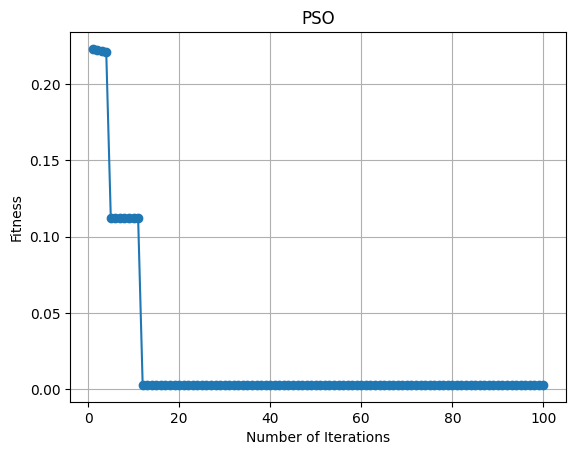

Best parameters found by GridSearchCV:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mean accuracy over all folds: 65.28%
Average Classification Report:
 {
    "0": {
        "precision": 0.61,
        "recall": 0.7,
        "f1-score": 0.6344444444444445,
        "support": 4.0
    },
    "1": {
        "precision": 0.7266666666666667,
        "recall": 0.62,
        "f1-score": 0.6514285714285715,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6683333333333332,
        "recall": 0.6599999999999999,
        "f1-score": 0.6429365079365079,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6725925925925925,
        "recall": 0.6527777777777779,
        "f1-score": 0.6412698412698413,
        "support": 8.6
    }
}


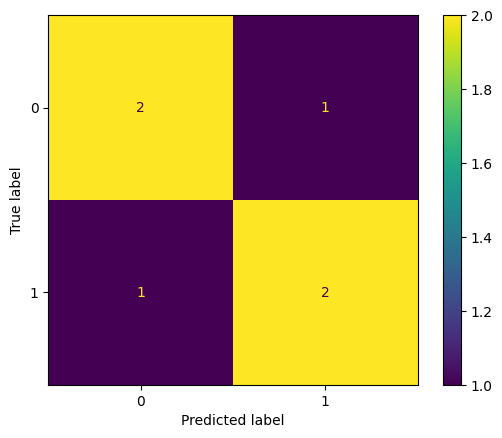

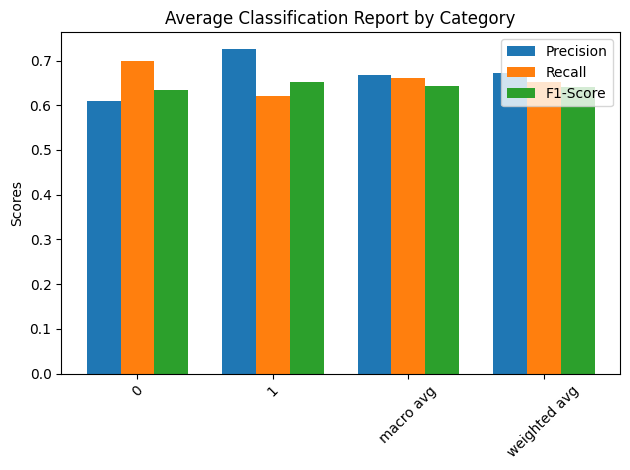

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

main(new_features, labels, param_grid, SVC)


# k-Nearest Neighbors (k-NN)

In [ ]:
import warnings

from sklearn.neighbors import KNeighborsClassifier

Iteration: 1, Best (PSO): 0.005769230769230774
Iteration: 2, Best (PSO): 0.005769230769230774
Iteration: 3, Best (PSO): 0.00461538461538462
Iteration: 4, Best (PSO): 0.00461538461538462
Iteration: 5, Best (PSO): 0.004230769230769234
Iteration: 6, Best (PSO): 0.00384615384615385
Iteration: 7, Best (PSO): 0.00307692307692308
Iteration: 8, Best (PSO): 0.00307692307692308
Iteration: 9, Best (PSO): 0.00307692307692308
Iteration: 10, Best (PSO): 0.00307692307692308
Iteration: 11, Best (PSO): 0.00307692307692308
Iteration: 12, Best (PSO): 0.00307692307692308
Iteration: 13, Best (PSO): 0.001923076923076925
Iteration: 14, Best (PSO): 0.001923076923076925
Iteration: 15, Best (PSO): 0.001923076923076925
Iteration: 16, Best (PSO): 0.001923076923076925
Iteration: 17, Best (PSO): 0.001923076923076925
Iteration: 18, Best (PSO): 0.001923076923076925
Iteration: 19, Best (PSO): 0.001923076923076925
Iteration: 20, Best (PSO): 0.001923076923076925
Iteration: 21, Best (PSO): 0.001923076923076925
Iteration:

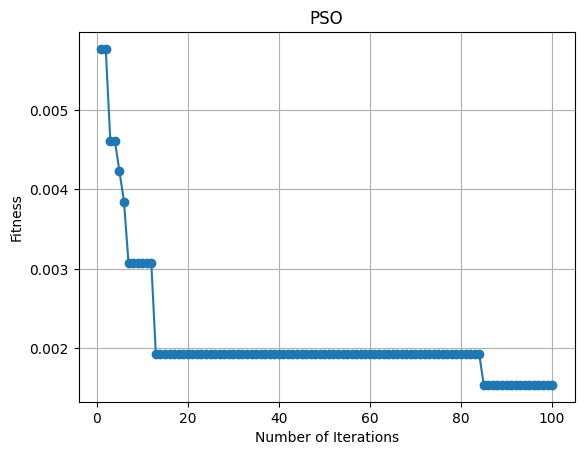

Best parameters found by GridSearchCV:  {'n_neighbors': 4}
Mean accuracy over all folds: 62.50%
Average Classification Report:
 {
    "0": {
        "precision": 0.605,
        "recall": 0.85,
        "f1-score": 0.6944444444444444,
        "support": 4.0
    },
    "1": {
        "precision": 0.49333333333333335,
        "recall": 0.42000000000000004,
        "f1-score": 0.45206349206349206,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5491666666666667,
        "recall": 0.635,
        "f1-score": 0.5732539682539682,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.5477777777777778,
        "recall": 0.625,
        "f1-score": 0.5682539682539682,
        "support": 8.6
    }
}


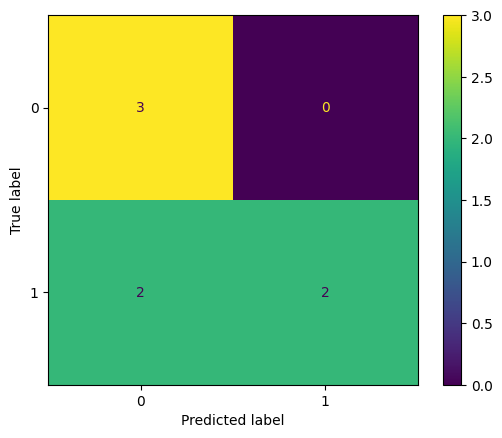

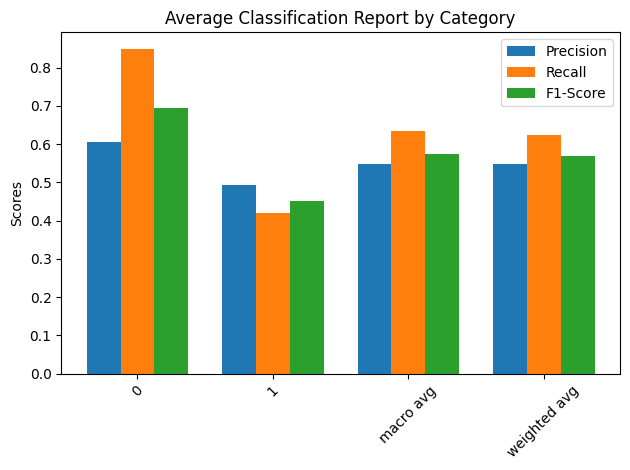

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"n_neighbors": np.arange(2, 10)}

main(new_features, labels, param_grid, KNeighborsClassifier)

# Logistic Regression

In [ ]:
import warnings

from sklearn.linear_model import LogisticRegression

Iteration: 1, Best (PSO): 0.33384615384615385
Iteration: 2, Best (PSO): 0.3330769230769231
Iteration: 3, Best (PSO): 0.3330769230769231
Iteration: 4, Best (PSO): 0.33269230769230773
Iteration: 5, Best (PSO): 0.3323076923076923
Iteration: 6, Best (PSO): 0.33192307692307693
Iteration: 7, Best (PSO): 0.33192307692307693
Iteration: 8, Best (PSO): 0.22269230769230766
Iteration: 9, Best (PSO): 0.22269230769230766
Iteration: 10, Best (PSO): 0.22269230769230766
Iteration: 11, Best (PSO): 0.22076923076923075
Iteration: 12, Best (PSO): 0.22076923076923075
Iteration: 13, Best (PSO): 0.22076923076923075
Iteration: 14, Best (PSO): 0.22076923076923075
Iteration: 15, Best (PSO): 0.22076923076923075
Iteration: 16, Best (PSO): 0.22076923076923075
Iteration: 17, Best (PSO): 0.22076923076923075
Iteration: 18, Best (PSO): 0.22076923076923075
Iteration: 19, Best (PSO): 0.22076923076923075
Iteration: 20, Best (PSO): 0.22076923076923075
Iteration: 21, Best (PSO): 0.22076923076923075
Iteration: 22, Best (PSO)

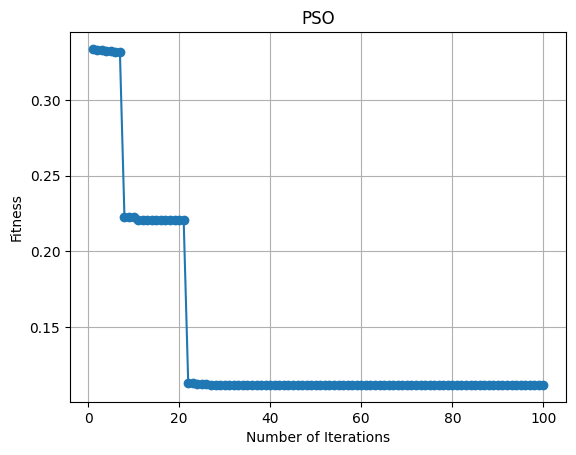

Best parameters found by GridSearchCV:  {'C': 0.01, 'solver': 'liblinear'}
Mean accuracy over all folds: 56.39%
Average Classification Report:
 {
    "0": {
        "precision": 0.61,
        "recall": 0.5,
        "f1-score": 0.5077777777777778,
        "support": 4.0
    },
    "1": {
        "precision": 0.5842857142857143,
        "recall": 0.63,
        "f1-score": 0.5932323232323233,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5971428571428572,
        "recall": 0.5650000000000001,
        "f1-score": 0.5505050505050505,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6004761904761905,
        "recall": 0.5638888888888889,
        "f1-score": 0.5516161616161617,
        "support": 8.6
    }
}


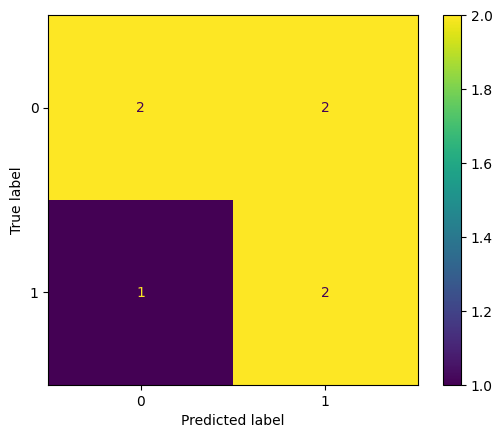

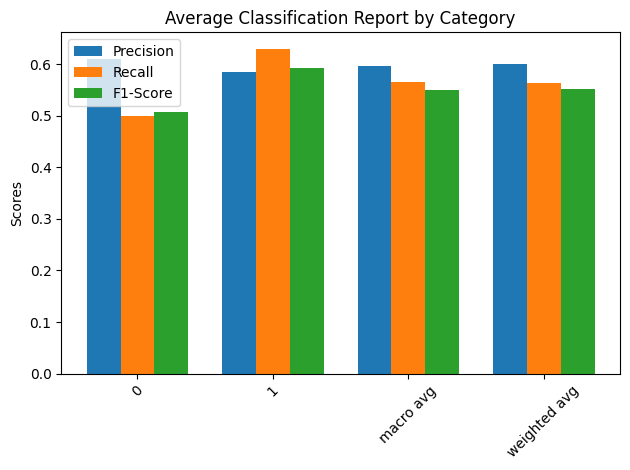

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

main(new_features, labels, param_grid, LogisticRegression)

# Decision Trees

In [ ]:
import warnings

from sklearn.tree import DecisionTreeClassifier

Iteration: 1, Best (PSO): 0.11461538461538466
Iteration: 2, Best (PSO): 0.00307692307692308
Iteration: 3, Best (PSO): 0.00307692307692308
Iteration: 4, Best (PSO): 0.00307692307692308
Iteration: 5, Best (PSO): 0.00307692307692308
Iteration: 6, Best (PSO): 0.00307692307692308
Iteration: 7, Best (PSO): 0.00307692307692308
Iteration: 8, Best (PSO): 0.00307692307692308
Iteration: 9, Best (PSO): 0.00307692307692308
Iteration: 10, Best (PSO): 0.00307692307692308
Iteration: 11, Best (PSO): 0.00307692307692308
Iteration: 12, Best (PSO): 0.00307692307692308
Iteration: 13, Best (PSO): 0.00307692307692308
Iteration: 14, Best (PSO): 0.00307692307692308
Iteration: 15, Best (PSO): 0.00307692307692308
Iteration: 16, Best (PSO): 0.00307692307692308
Iteration: 17, Best (PSO): 0.0026923076923076944
Iteration: 18, Best (PSO): 0.0026923076923076944
Iteration: 19, Best (PSO): 0.0026923076923076944
Iteration: 20, Best (PSO): 0.0026923076923076944
Iteration: 21, Best (PSO): 0.0026923076923076944
Iteration: 2

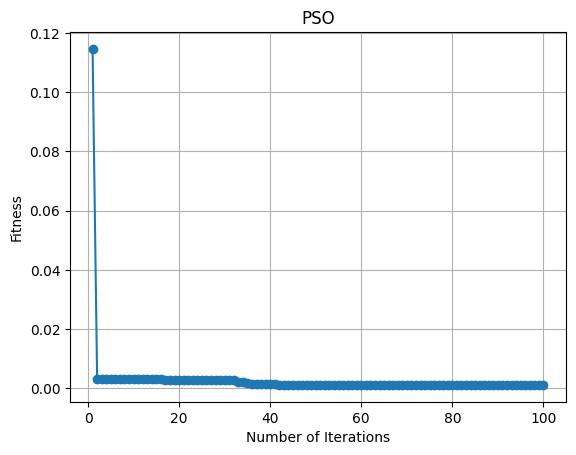

Best parameters found by GridSearchCV:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean accuracy over all folds: 60.56%
Average Classification Report:
 {
    "0": {
        "precision": 0.5433333333333333,
        "recall": 0.6,
        "f1-score": 0.5592063492063492,
        "support": 4.0
    },
    "1": {
        "precision": 0.6933333333333332,
        "recall": 0.61,
        "f1-score": 0.6357720057720059,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6183333333333334,
        "recall": 0.6050000000000001,
        "f1-score": 0.5974891774891774,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6237037037037036,
        "recall": 0.6055555555555555,
        "f1-score": 0.6003318903318904,
        "support": 8.6
    }
}


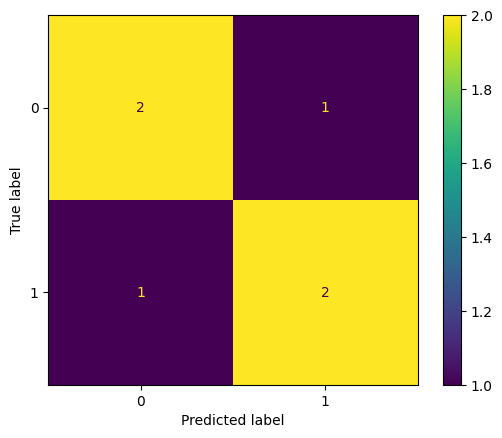

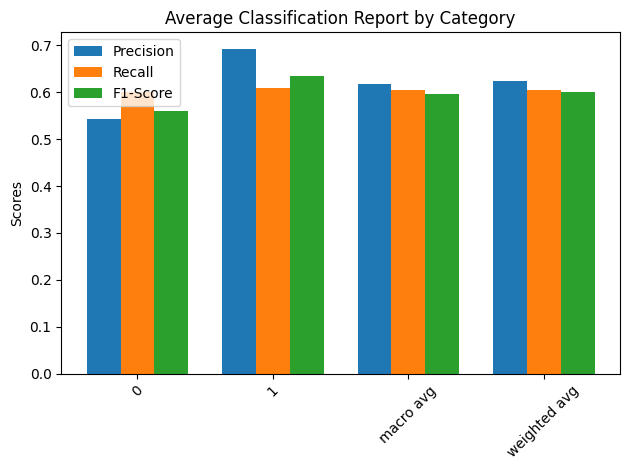

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

main(new_features, labels, param_grid, DecisionTreeClassifier)

# Random Forest

In [ ]:
import warnings

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

main(features, labels, param_grid, RandomForestClassifier)

# XGBoost

In [16]:
import warnings

import xgboost as xgb

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

main(features, labels, param_grid, xgb_model)

# All Info

In [20]:
import warnings

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Iteration: 1, Best (PSO): 0.05027728085867618
Iteration: 2, Best (PSO): 0.027638640429338147
Iteration: 3, Best (PSO): 0.0050000000000000044
Iteration: 4, Best (PSO): 0.0050000000000000044
Iteration: 5, Best (PSO): 0.0050000000000000044
Iteration: 6, Best (PSO): 0.0050000000000000044
Iteration: 7, Best (PSO): 0.0050000000000000044
Iteration: 8, Best (PSO): 0.0050000000000000044
Iteration: 9, Best (PSO): 0.0050000000000000044
Iteration: 10, Best (PSO): 0.0050000000000000044
Iteration: 11, Best (PSO): 0.0050000000000000044
Iteration: 12, Best (PSO): 0.0050000000000000044
Iteration: 13, Best (PSO): 0.0050000000000000044
Iteration: 14, Best (PSO): 0.0050000000000000044
Iteration: 15, Best (PSO): 0.0050000000000000044
Iteration: 16, Best (PSO): 0.0050000000000000044
Iteration: 17, Best (PSO): 0.0050000000000000044
Iteration: 18, Best (PSO): 0.0050000000000000044
Iteration: 19, Best (PSO): 0.0050000000000000044
Iteration: 20, Best (PSO): 0.0050000000000000044
Iteration: 21, Best (PSO): 0.005

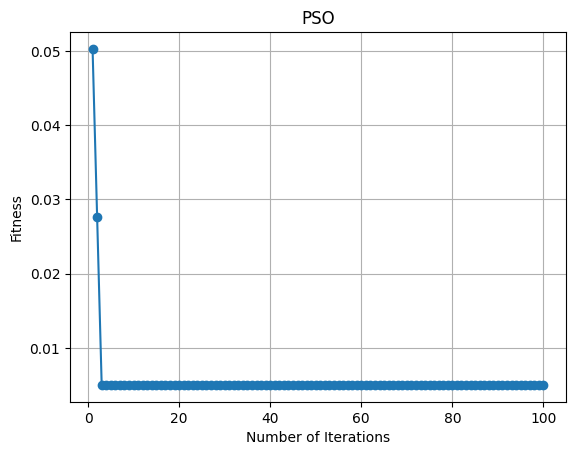

Best parameters found by GridSearchCV:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mean accuracy over all folds: 69.44%
Average Classification Report:
 {
    "0": {
        "precision": 0.5666666666666667,
        "recall": 0.6,
        "f1-score": 0.5742857142857144,
        "support": 4.0
    },
    "1": {
        "precision": 0.7533333333333333,
        "recall": 0.78,
        "f1-score": 0.7321212121212122,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6599999999999999,
        "recall": 0.6900000000000001,
        "f1-score": 0.6532034632034633,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6611111111111111,
        "recall": 0.6944444444444444,
        "f1-score": 0.6560461760461761,
        "support": 8.6
    }
}


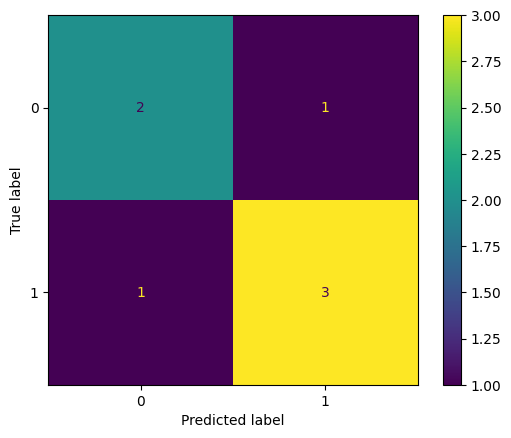

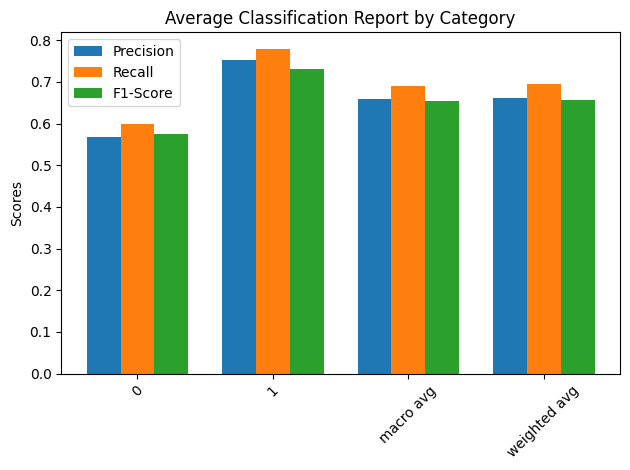

Iteration: 1, Best (PSO): 0.14198568872987483
Iteration: 2, Best (PSO): 0.14198568872987483
Iteration: 3, Best (PSO): 0.09593917710196785
Iteration: 4, Best (PSO): 0.09593917710196785
Iteration: 5, Best (PSO): 0.09593917710196785
Iteration: 6, Best (PSO): 0.09593917710196785
Iteration: 7, Best (PSO): 0.09593917710196785
Iteration: 8, Best (PSO): 0.09593917710196785
Iteration: 9, Best (PSO): 0.09593917710196785
Iteration: 10, Best (PSO): 0.09555456171735247
Iteration: 11, Best (PSO): 0.09555456171735247
Iteration: 12, Best (PSO): 0.09555456171735247
Iteration: 13, Best (PSO): 0.09555456171735247
Iteration: 14, Best (PSO): 0.09555456171735247
Iteration: 15, Best (PSO): 0.09555456171735247
Iteration: 16, Best (PSO): 0.09555456171735247
Iteration: 17, Best (PSO): 0.09555456171735247
Iteration: 18, Best (PSO): 0.09555456171735247
Iteration: 19, Best (PSO): 0.09555456171735247
Iteration: 20, Best (PSO): 0.09555456171735247
Iteration: 21, Best (PSO): 0.09555456171735247
Iteration: 22, Best (P

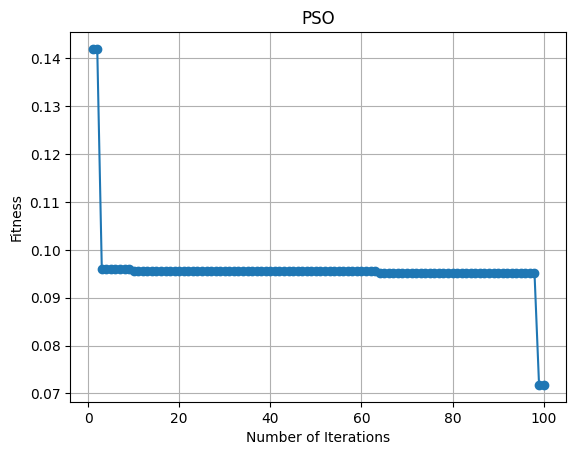

Best parameters found by GridSearchCV:  {'n_neighbors': 3}
Mean accuracy over all folds: 74.44%
Average Classification Report:
 {
    "0": {
        "precision": 0.8333333333333334,
        "recall": 0.6,
        "f1-score": 0.64,
        "support": 4.0
    },
    "1": {
        "precision": 0.7726190476190475,
        "recall": 0.86,
        "f1-score": 0.7805128205128204,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.8029761904761903,
        "recall": 0.73,
        "f1-score": 0.7102564102564103,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7996031746031745,
        "recall": 0.7444444444444445,
        "f1-score": 0.7180626780626781,
        "support": 8.6
    }
}


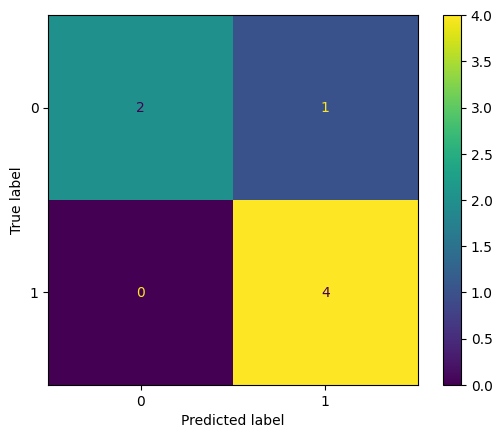

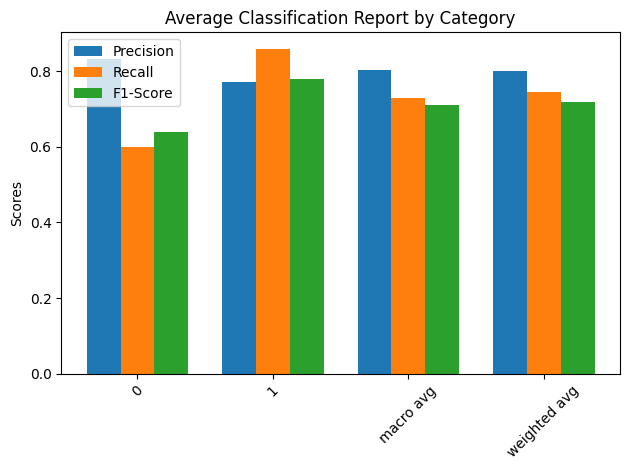

Iteration: 1, Best (PSO): 0.028023255813953533
Iteration: 2, Best (PSO): 0.028023255813953533
Iteration: 3, Best (PSO): 0.028023255813953533
Iteration: 4, Best (PSO): 0.028023255813953533
Iteration: 5, Best (PSO): 0.028023255813953533
Iteration: 6, Best (PSO): 0.028023255813953533
Iteration: 7, Best (PSO): 0.028023255813953533
Iteration: 8, Best (PSO): 0.028023255813953533
Iteration: 9, Best (PSO): 0.028023255813953533
Iteration: 10, Best (PSO): 0.028023255813953533
Iteration: 11, Best (PSO): 0.028023255813953533
Iteration: 12, Best (PSO): 0.027638640429338147
Iteration: 13, Best (PSO): 0.027638640429338147
Iteration: 14, Best (PSO): 0.02725402504472276
Iteration: 15, Best (PSO): 0.02725402504472276
Iteration: 16, Best (PSO): 0.02725402504472276
Iteration: 17, Best (PSO): 0.02725402504472276
Iteration: 18, Best (PSO): 0.02725402504472276
Iteration: 19, Best (PSO): 0.02725402504472276
Iteration: 20, Best (PSO): 0.02725402504472276
Iteration: 21, Best (PSO): 0.02725402504472276
Iteration

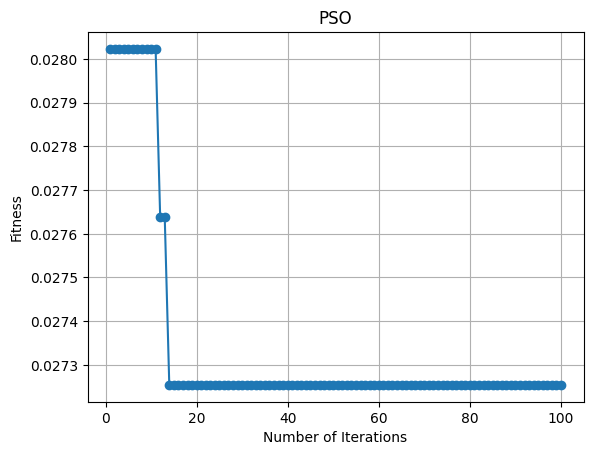

Best parameters found by GridSearchCV:  {'C': 10, 'solver': 'liblinear'}
Mean accuracy over all folds: 72.22%
Average Classification Report:
 {
    "0": {
        "precision": 0.7142857142857142,
        "recall": 0.8,
        "f1-score": 0.7368831168831169,
        "support": 4.0
    },
    "1": {
        "precision": 0.8,
        "recall": 0.6599999999999999,
        "f1-score": 0.6961038961038961,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7571428571428571,
        "recall": 0.73,
        "f1-score": 0.7164935064935065,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7619047619047619,
        "recall": 0.7222222222222222,
        "f1-score": 0.7142279942279942,
        "support": 8.6
    }
}


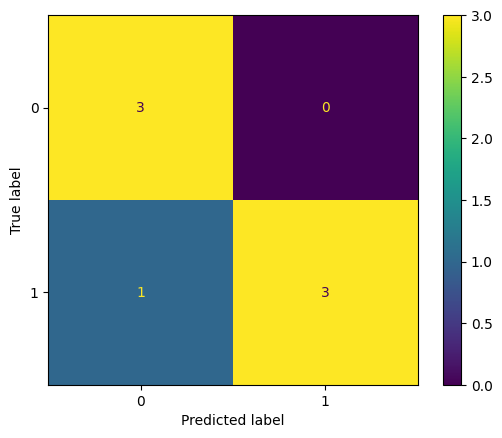

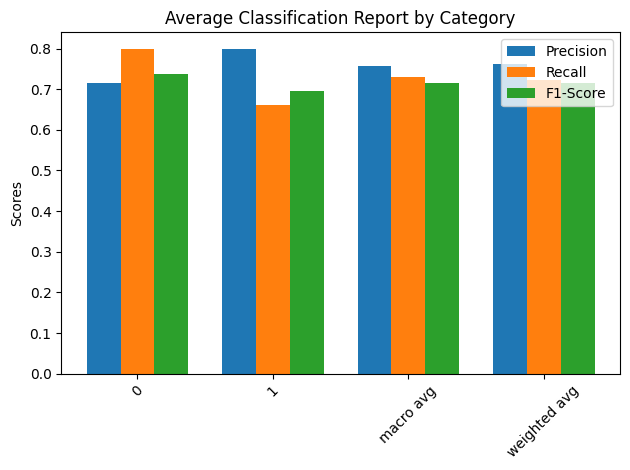

Iteration: 1, Best (PSO): 0.00153846153846154
Iteration: 2, Best (PSO): 0.00153846153846154
Iteration: 3, Best (PSO): 0.00076923076923077
Iteration: 4, Best (PSO): 0.000384615384615385
Iteration: 5, Best (PSO): 0.000384615384615385
Iteration: 6, Best (PSO): 0.000384615384615385
Iteration: 7, Best (PSO): 0.000384615384615385
Iteration: 8, Best (PSO): 0.000384615384615385
Iteration: 9, Best (PSO): 0.000384615384615385
Iteration: 10, Best (PSO): 0.000384615384615385
Iteration: 11, Best (PSO): 0.000384615384615385
Iteration: 12, Best (PSO): 0.000384615384615385
Iteration: 13, Best (PSO): 0.000384615384615385
Iteration: 14, Best (PSO): 0.000384615384615385
Iteration: 15, Best (PSO): 0.000384615384615385
Iteration: 16, Best (PSO): 0.000384615384615385
Iteration: 17, Best (PSO): 0.000384615384615385
Iteration: 18, Best (PSO): 0.000384615384615385
Iteration: 19, Best (PSO): 0.000384615384615385
Iteration: 20, Best (PSO): 0.000384615384615385
Iteration: 21, Best (PSO): 0.000384615384615385
Iter

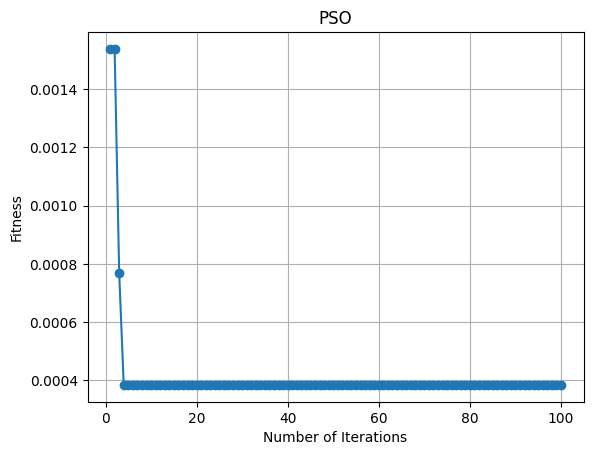

Best parameters found by GridSearchCV:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mean accuracy over all folds: 51.11%
Average Classification Report:
 {
    "0": {
        "precision": 0.48571428571428565,
        "recall": 0.5,
        "f1-score": 0.4805194805194805,
        "support": 4.0
    },
    "1": {
        "precision": 0.54,
        "recall": 0.53,
        "f1-score": 0.5193650793650793,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5128571428571429,
        "recall": 0.515,
        "f1-score": 0.49994227994228,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.5158730158730159,
        "recall": 0.5111111111111111,
        "f1-score": 0.4992784992784993,
        "support": 8.6
    }
}


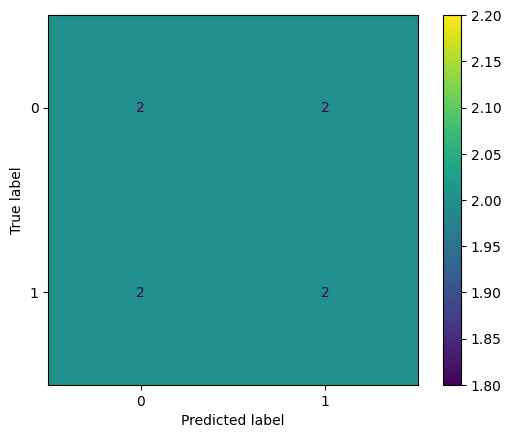

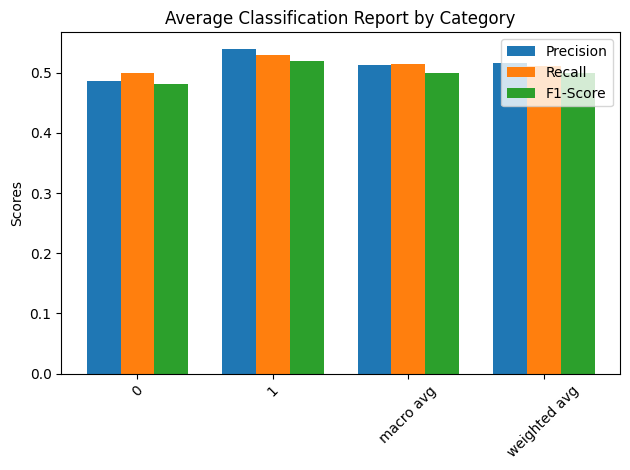

Iteration: 1, Best (PSO): 0.004557926829268297
Iteration: 2, Best (PSO): 0.00446646341463415
Iteration: 3, Best (PSO): 0.004314024390243906
Iteration: 4, Best (PSO): 0.004161585365853662
Iteration: 5, Best (PSO): 0.003917682926829272
Iteration: 6, Best (PSO): 0.003887195121951223
Iteration: 7, Best (PSO): 0.003887195121951223
Iteration: 8, Best (PSO): 0.003887195121951223
Iteration: 9, Best (PSO): 0.003887195121951223
Iteration: 10, Best (PSO): 0.003887195121951223
Iteration: 11, Best (PSO): 0.003887195121951223
Iteration: 12, Best (PSO): 0.003856707317073174
Iteration: 13, Best (PSO): 0.003856707317073174
Iteration: 14, Best (PSO): 0.003856707317073174
Iteration: 15, Best (PSO): 0.0038414634146341498
Iteration: 16, Best (PSO): 0.0038414634146341498
Iteration: 17, Best (PSO): 0.0038414634146341498
Iteration: 18, Best (PSO): 0.0038414634146341498
Iteration: 19, Best (PSO): 0.0038414634146341498
Iteration: 20, Best (PSO): 0.0038414634146341498
Iteration: 21, Best (PSO): 0.003841463414634

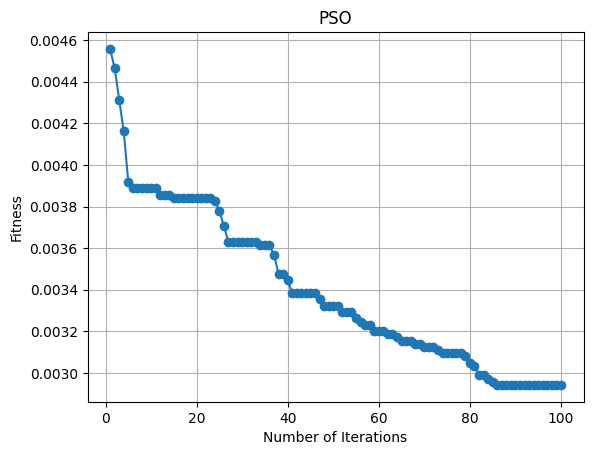

Best parameters found by GridSearchCV:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean accuracy over all folds: 58.33%
Average Classification Report:
 {
    "0": {
        "precision": 0.5533333333333333,
        "recall": 0.6,
        "f1-score": 0.5476190476190477,
        "support": 4.0
    },
    "1": {
        "precision": 0.6876190476190476,
        "recall": 0.5700000000000001,
        "f1-score": 0.5676190476190477,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6204761904761905,
        "recall": 0.585,
        "f1-score": 0.5576190476190477,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6279365079365079,
        "recall": 0.5833333333333334,
        "f1-score": 0.5587301587301587,
        "support": 8.6
    }
}


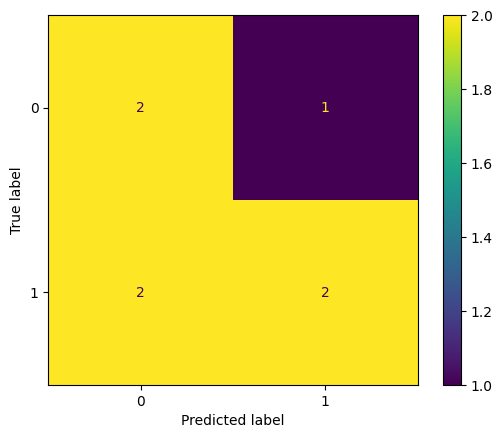

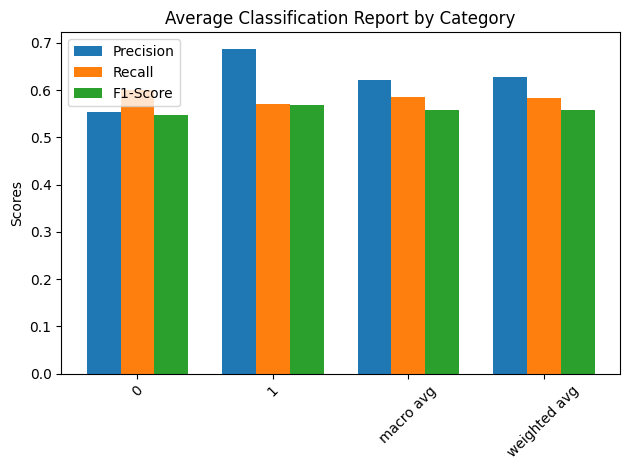

In [21]:
# Suppress all warnings
warnings.filterwarnings("ignore")

all_results = {}

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

all_results["SVM"] = main(new_features, labels, param_grid, SVC)

param_grid = {"n_neighbors": np.arange(2, 10)}

all_results["KNeighborsClassifier"] = main(new_features, labels, param_grid, KNeighborsClassifier)

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

all_results["LogisticRegression"] = main(new_features, labels, param_grid, LogisticRegression)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

all_results["DecisionTreeClassifier"] =main(new_features, labels, param_grid, DecisionTreeClassifier)

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

all_results["XGBoost"] = (
    main(features, labels, param_grid, xgb_model)
)

In [22]:
all_results

{'SVM': 69.44444444444444,
 'KNeighborsClassifier': 74.44444444444443,
 'LogisticRegression': 72.22222222222221,
 'DecisionTreeClassifier': 51.11111111111111,
 'XGBoost': 58.333333333333336}

In [23]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(all_results.items()), columns=['Classifier', 'Accuracy'])

# Save DataFrame to CSV file
df.to_csv('/content/ML_PCA_PSO.csv', index=False)
